In [1]:
import joblib

X_train, X_test, y_train, y_test = joblib.load('artifacts/final_census_data.pkl')

# Baseline Model Training

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.base import ClassifierMixin

def evaluate_model(model: ClassifierMixin, X_test, y_test, name=None):
    # Predict labels
    y_pred = model.predict(X_test)
    
    # Predict probabilities / scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    # Collect metrics
    metrics = {
        "Model": name if name else model.__class__.__name__,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average='weighted'),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_proba)
    
    return metrics, y_pred, y_proba

In [3]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight='balanced'),
    "Ridge Classifier": RidgeClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(class_weight='balanced'),
    "XGBoost": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )
}

In [4]:
from sklearn.metrics import average_precision_score

results = []
y_probas = {}
ap_scores = {}  # store average precision

for name, model in models.items():
    model.fit(X_train, y_train)
    
    metrics, y_pred, y_proba = evaluate_model(model, X_test, y_test, name)
    results.append(metrics)

     # Get probabilities or decision function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        continue  # skip if model doesn't support scoring
    
    # Save
    y_probas[name] = y_scores
    ap_scores[name] = average_precision_score(y_test, y_scores)
    
    print(f"{name} model trained.")

Logistic Regression model trained.
Ridge Classifier model trained.
Decision Tree model trained.
Random Forest model trained.
Gradient Boosting model trained.
SVM model trained.
XGBoost model trained.


Use F1-score

Why: Balances precision and recall, so it doesn’t favor the majority class.

When: After SMOTE, classes are balanced in training, but your test set should stay imbalanced — so the F1 gives a fairer view.

In [5]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Rank models by Accuracy (descending)
ranked_results = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)
ranked_results

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,XGBoost,0.858739,0.759567,0.620666,0.853670,0.912086
1,Gradient Boosting,0.855904,0.782852,0.571040,0.847667,0.908645
2,Random Forest,0.804870,0.570229,0.830727,0.815186,0.895478
3,Decision Tree,0.795030,0.553922,0.845003,0.806783,0.888374
4,SVM,0.768679,0.517227,0.857240,0.783454,0.877682
5,Logistic Regression,0.761841,0.508590,0.865398,0.777438,0.878772
6,Ridge Classifier,0.756004,0.501566,0.870836,0.772246,0.875954


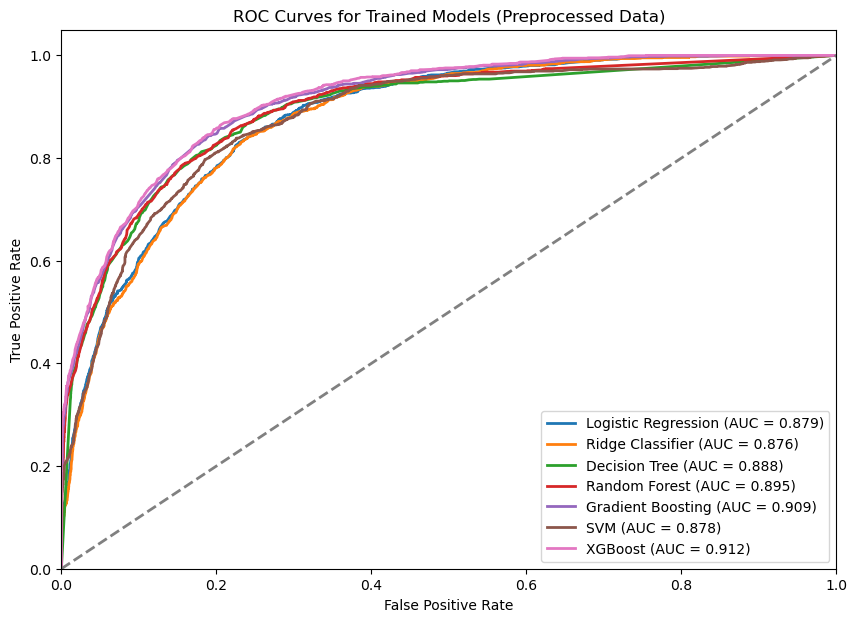

In [6]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))

for name, y_proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Trained Models (Preprocessed Data)")
plt.legend(loc="lower right")
plt.show()

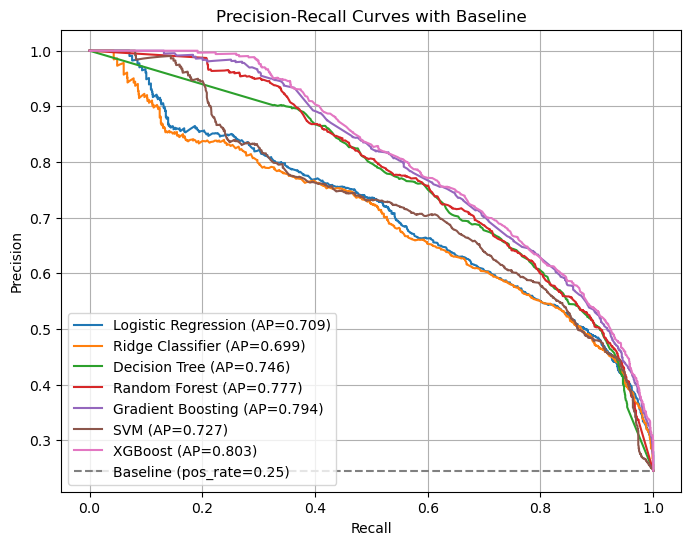

In [7]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Proportion of positive class in test set
pos_rate = np.mean(y_test)

plt.figure(figsize=(8,6))
for name, y_scores in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Add baseline
plt.hlines(pos_rate, 0, 1, colors="gray", linestyles="--", label=f"Baseline (pos_rate={pos_rate:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Baseline")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
sorted(ap_scores.items(), key=lambda item: -item[1])

[('XGBoost', 0.8033273994614102),
 ('Gradient Boosting', 0.7942917612374716),
 ('Random Forest', 0.7765394687762657),
 ('Decision Tree', 0.7463240874126886),
 ('SVM', 0.7269315946688013),
 ('Logistic Regression', 0.7092125765922882),
 ('Ridge Classifier', 0.6987451628183692)]

# Classification Report

In [9]:
from sklearn.metrics import classification_report

y_pred = models["Gradient Boosting"].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4525
           1       0.78      0.57      0.66      1471

    accuracy                           0.86      5996
   macro avg       0.83      0.76      0.78      5996
weighted avg       0.85      0.86      0.85      5996



In [10]:
y_pred = models["Random Forest"].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4525
           1       0.57      0.83      0.68      1471

    accuracy                           0.80      5996
   macro avg       0.75      0.81      0.77      5996
weighted avg       0.85      0.80      0.82      5996



In [11]:
y_pred = models["XGBoost"].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4525
           1       0.76      0.62      0.68      1471

    accuracy                           0.86      5996
   macro avg       0.82      0.78      0.80      5996
weighted avg       0.85      0.86      0.85      5996



# Hyperparameter Tuning

## Random Forest

In [12]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_rf.fit(X_train, y_train)
best_rf = rand_rf.best_estimator_
print("Best RF Params:", rand_rf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}


In [13]:
evaluate_model(rand_rf, X_test, y_test, "Random Forest (Randomized Search)")[0]

{'Model': 'Random Forest (Randomized Search)',
 'Accuracy': 0.8085390260173448,
 'Precision': 0.5745958429561201,
 'Recall': 0.8456832087015635,
 'F1': 0.8188602079018846,
 'ROC-AUC': 0.9060088412813472}

In [14]:
y_pred = rand_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4525
           1       0.57      0.85      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.82      0.77      5996
weighted avg       0.85      0.81      0.82      5996



## Gradient Boosting

In [15]:
# Define the model
gb = GradientBoostingClassifier(random_state=42)

# Define the parameter distribution
gb_param_dist = {
    "n_estimators": [100, 200, 300],   # number of boosting stages
    "learning_rate": [0.001, 0.01, 0.05, 0.1],  # shrinkage
    "max_depth": [3, 5, 7, 10],                  # depth of individual trees
    "min_samples_split": [2, 5, 10],             # min samples to split a node
    "min_samples_leaf": [1, 2, 4],               # min samples in a leaf
    "max_features": ["sqrt", "log2", None],  # feature sampling
    "subsample": [0.6, 0.8, 1.0]                 # stochastic gradient boosting
}

# Randomized search
rand_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_dist,
    n_iter=10,
    scoring="accuracy",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rand_gb.fit(X_train, y_train)

# Best estimator and params
best_gb = rand_gb.best_estimator_
print("Best GB Params:", rand_gb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best GB Params: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}


In [16]:
evaluate_model(rand_gb, X_test, y_test, "Random Forest (Randomized Search)")[0]

{'Model': 'Random Forest (Randomized Search)',
 'Accuracy': 0.8585723815877252,
 'Precision': 0.766923736075407,
 'Recall': 0.6084296397008837,
 'F1': 0.8527215668495334,
 'ROC-AUC': 0.9120903959046164}

## XGBoost

In [17]:
# Do randomized search for XGBoost
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_xgb.fit(X_train, y_train)
best_xgb = rand_xgb.best_estimator_
print("Best XGB Params:", rand_xgb.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB Params: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}


In [24]:
evaluate_model(rand_xgb, X_test, y_test, "XGBoost (Randomized Search)")[0]

{'Model': 'XGBoost (Randomized Search)',
 'Accuracy': 0.8530837372555574,
 'Precision': 0.753686036426713,
 'Recall': 0.5935792349726776,
 'F1': 0.8467977211343956,
 'ROC-AUC': 0.9097416705664123}

# Final Model Evaluation

In [18]:
# Collect final models
final_models = {
    "Random Forest (Random CV)": best_rf,
    "Gradient Boosting (Random CV)": best_gb,
    "XGBoost (Random CV)": best_xgb,
    "Logistic Regression": models["Logistic Regression"],
    "Ridge Classifier": models["Ridge Classifier"],
    "Decision Tree": models["Decision Tree"],
    "SVM": models["SVM"],
    "Random Forest": models["Random Forest"],
    "Gradient Boosting": models["Gradient Boosting"],
    "XGBoost": models["XGBoost"]
}

In [19]:
# Create results list
final_results = []
for name, model in final_models.items():
    metrics, y_pred, y_proba = evaluate_model(model, X_test, y_test, name)
    final_results.append(metrics)
    
# Convert to DataFrame
final_results_df = pd.DataFrame(final_results)
# Rank by F1 score
final_ranked_results = final_results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)
final_ranked_results

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,XGBoost,0.858739,0.759567,0.620666,0.853670,0.912086
1,Gradient Boosting (Random CV),0.858572,0.766924,0.608430,0.852722,0.912090
2,XGBoost (Random CV),0.858239,0.767442,0.605710,0.852238,0.911910
3,Gradient Boosting,0.855904,0.782852,0.571040,0.847667,0.908645
4,Random Forest (Random CV),0.808539,0.574596,0.845683,0.818860,0.906009
5,Random Forest,0.804870,0.570229,0.830727,0.815186,0.895478
6,Decision Tree,0.795030,0.553922,0.845003,0.806783,0.888374
7,SVM,0.768679,0.517227,0.857240,0.783454,0.877682
8,Logistic Regression,0.761841,0.508590,0.865398,0.777438,0.878772
9,Ridge Classifier,0.756004,0.501566,0.870836,0.772246,0.875954
